In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re

#plot
import matplotlib.pyplot as plt

In [2]:
from P_UTILS import cleaning_mouvement_records, avg_diff_linbr
import config

# Download initial data

In [3]:
path_initial_data = config.path_initial_data
p = glob.glob(os.path.join(path_initial_data,'log_*.csv'))
print('There is %d log files'%len(p))

There is 74 log files


In [4]:
li_df = []
p = glob.glob(os.path.join(path_initial_data,'log_*.csv'))
print('There is %d log files'%len(p))
for path in p:
    log_name = path.split('\\')[-1].split('.')[0]
    df = pd.read_csv(path,sep=';', names=['Timestamp', 'Serialnumber_Tag', 'TagID_Pen_HenID', 'Zone', 'Signal','U1','U2']) 
    #add name of the log to verify issues (e.g. in TagID_Pen_HenID)
    df['log_file_name'] = log_name 
    #add order in timestamp (as there is no miliseconds recorded)
    #df['ts_order'] = df.index.copy()
    print(df.shape)
    li_df.append(df)
df = pd.concat(li_df)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d.%m.%Y %H:%M:%S") #faster with specified format or parse_dates
print(df.shape)
df.head(5)

There is 74 log files
(94817, 8)
(94800, 8)
(95180, 8)
(94907, 8)
(95277, 8)
(94392, 8)
(95155, 8)
(94394, 8)
(93649, 8)
(95085, 8)
(94884, 8)
(94301, 8)
(95172, 8)
(94512, 8)
(94652, 8)
(94650, 8)
(94610, 8)
(94852, 8)
(94585, 8)
(94268, 8)
(94874, 8)
(95047, 8)
(93950, 8)
(94985, 8)
(94975, 8)
(94539, 8)
(94783, 8)
(94529, 8)
(95146, 8)
(94374, 8)
(94377, 8)
(95088, 8)
(93977, 8)
(94594, 8)
(94387, 8)
(94227, 8)
(94364, 8)
(93550, 8)
(94427, 8)
(93863, 8)
(94227, 8)
(95005, 8)
(93547, 8)
(94727, 8)
(93891, 8)
(93759, 8)
(94113, 8)
(94146, 8)
(95050, 8)
(93827, 8)
(94759, 8)
(94535, 8)
(94107, 8)
(94904, 8)
(93852, 8)
(94641, 8)
(93790, 8)
(95100, 8)
(93860, 8)
(95424, 8)
(94039, 8)
(94961, 8)
(93823, 8)
(94877, 8)
(93673, 8)
(93984, 8)
(94351, 8)
(92980, 8)
(95043, 8)
(93956, 8)
(94778, 8)
(93904, 8)
(95027, 8)
(74713, 8)
(6971571, 8)


,Timestamp,Serialnumber_Tag,TagID_Pen_HenID,Zone,Signal,U1,U2,log_file_name
0,2019-07-07 22:09:28,02001560,060 4B,Rampe 1-5,12,2,2,log_00000006
1,2019-07-07 22:09:28,020015C6,067 4L,Rampe 1-5,14,2,2,log_00000006
2,2019-07-07 22:09:29,02001560,060 4B,Einstreu 1-5,12,2,1,log_00000006
3,2019-07-07 22:09:29,020015C6,067 4L,Einstreu 1-5,14,2,1,log_00000006
4,2019-07-07 22:09:29,02001560,060 4B,Rampe 1-5,12,2,2,log_00000006


# Turn data into appropriate form

#### TagID_Pen_HenID variable

In [5]:
#some more info about the '_' case
#df['false'] = df['TagID_Pen_HenID'].map(lambda x: '_' in x)
#df[df['false']]['TagID_Pen_HenID'].value_counts() #only 103_6V happend to have a '_', and it appears 34'351 times
#df[df['TagID_Pen_HenID']=='15C3']['log_file_name'].value_counts() #-> mostly from same log file:log_00000079 (5607 such cases)
#df[df['TagID_Pen_HenID']=='15C3']['Zone'].value_counts() #mostly box zones are concerned but not only
#df[df['TagID_Pen_HenID']=='103 6V']
#--> no 103 6V, all have the '_'

In [6]:
#Remove record associated to wrong HenID
df['TagID_Pen_HenID'] = df['TagID_Pen_HenID'].map(lambda x: x.replace('_',' '))
x0 = df[df['TagID_Pen_HenID']=='15C3'].shape[0]
df = df[df['TagID_Pen_HenID']!='15C3']
print('We remove %d records due to an unkown TagID_Pen_HenID value: 15C3, we are left with %d records'%(x0, df.shape[0]))
df['HenID'] = df['TagID_Pen_HenID'].map(lambda x: x.split(' ')[-1])
df['PenID'] = df['TagID_Pen_HenID'].map(lambda x: x.split(' ')[-1][0:-1].strip())
df.head(3)

We remove 5886 records due to an unkown TagID_Pen_HenID value: 15C3, we are left with 6965685 records


,Timestamp,Serialnumber_Tag,TagID_Pen_HenID,Zone,Signal,U1,U2,log_file_name,HenID,PenID
0,2019-07-07 22:09:28,02001560,060 4B,Rampe 1-5,12,2,2,log_00000006,4B,4
1,2019-07-07 22:09:28,020015C6,067 4L,Rampe 1-5,14,2,2,log_00000006,4L,4
2,2019-07-07 22:09:29,02001560,060 4B,Einstreu 1-5,12,2,1,log_00000006,4B,4


#### keep only usefull variables

In [7]:
df = df.filter(['Timestamp', 'HenID', 'Zone','PenID','Signal']).reset_index(drop=True) #'df.head(3)'
df.head(3)

,Timestamp,HenID,Zone,PenID,Signal
0,2019-07-07 22:09:28,4B,Rampe 1-5,4,12
1,2019-07-07 22:09:28,4L,Rampe 1-5,4,14
2,2019-07-07 22:09:29,4B,Einstreu 1-5,4,12


In [8]:
#verify dates format
#df.iloc[0]['day'] == dt.datetime.strptime('2019-07-07', '%Y-%m-%d')

# Cleaning

In [9]:
START_TIME = time.clock()

In [10]:
nbr_sec = config.nbr_sec

#choose folder names
path_initial_data = config.path_initial_data
path_extracted_data = config.path_extracted_data

#list of date to be removed due to health assessment or anything else
li_date2remove = config.li_date2remove

#list of HenID and PenID that should exists, everything not in this list will not be taken into account and a wargnin will be send with
#all the associated information
#should be string, but will be converted into string in anycase
li_henID = config.li_henID
li_penID = config.li_penID

In [11]:
df['test_correct_HenID'] = df['HenID'].map(lambda x: x in li_henID)
df['test_correct_PenID'] = df['PenID'].map(lambda x: x in li_penID)
df = df[(df['test_correct_HenID']) & (df['test_correct_PenID'])]

#### Remove dates with health care

In [12]:
#add day variable
df['day'] = df['Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
li_date2remove = config.li_date2remove
li_date2remove = [dt.datetime.strptime(x, '%Y-%m-%d') for x in li_date2remove]
df['date_toberemoved'] = df['day'].map(lambda x: x in li_date2remove)
#df['date_toberemoved'].value_counts()
df = df[~df['date_toberemoved']]
print(df.shape)
df.head(3)

(4644977, 9)


,Timestamp,HenID,Zone,PenID,Signal,test_correct_HenID,test_correct_PenID,day,date_toberemoved
0,2019-07-07 22:09:28,4B,Rampe 1-5,4,12,True,True,2019-07-07,False
1,2019-07-07 22:09:28,4L,Rampe 1-5,4,14,True,True,2019-07-07,False
2,2019-07-07 22:09:29,4B,Einstreu 1-5,4,12,True,True,2019-07-07,False


#### playground 1

In [13]:
df = df.sort_values(['Timestamp'], ascending=True) #ts_order
df.head(5)

,Timestamp,HenID,Zone,PenID,Signal,test_correct_HenID,test_correct_PenID,day,date_toberemoved
0,2019-07-07 22:09:28,4B,Rampe 1-5,4,12,True,True,2019-07-07,False
1,2019-07-07 22:09:28,4L,Rampe 1-5,4,14,True,True,2019-07-07,False
2,2019-07-07 22:09:29,4B,Einstreu 1-5,4,12,True,True,2019-07-07,False
3,2019-07-07 22:09:29,4L,Einstreu 1-5,4,14,True,True,2019-07-07,False
4,2019-07-07 22:09:29,4B,Rampe 1-5,4,12,True,True,2019-07-07,False


In [14]:
df_test = df.groupby(['PenID','HenID'])['Zone','Timestamp'].agg(lambda x: tuple(x)).reset_index()
df_test.head(3)

,PenID,HenID,Zone,Timestamp
0,1,1A,"(Rampe 1-5, Einstreu 1-5, Rampe 1-5, Einstreu ...","(2019-07-07 22:12:16, 2019-07-07 22:12:18, 201..."
1,1,1B,"(Einstreu 1-5, Rampe 1-5, Einstreu 1-5, Rampe ...","(2019-07-08 04:01:32, 2019-07-08 05:21:51, 201..."
2,1,1C,"(Rampe 1-5, Einstreu 1-5, Rampe 1-5, Einstreu ...","(2019-07-08 03:54:31, 2019-07-08 03:54:34, 201..."


In [15]:
def pattern_occurence(li):
    s = ' '.join(li)
    r = re.findall(r'Box\d+ Rampe \d+-\d+ Box\d+',s)
    return r

In [120]:
df_test['all_occurence_box_rampe_box'] = df_test['Zone'].map(lambda x: pattern_occurence(x))
df_test['nbr_occurence'] = df_test['all_occurence_box_rampe_box'].map(lambda x: len(x))
df_test

,PenID,HenID,Zone,Timestamp,all_occurence_box_rampe_box,nbr_occurence
0,1,1A,"(Rampe 1-5, Einstreu 1-5, Rampe 1-5, Einstreu ...","(2019-07-07 22:12:16, 2019-07-07 22:12:18, 201...","[Box1 Rampe 1-5 Box1, Box1 Rampe 1-5 Box1, Box...",272
1,1,1B,"(Einstreu 1-5, Rampe 1-5, Einstreu 1-5, Rampe ...","(2019-07-08 04:01:32, 2019-07-08 05:21:51, 201...","[Box1 Rampe 1-5 Box1, Box1 Rampe 1-5 Box2, Box...",548
2,1,1C,"(Rampe 1-5, Einstreu 1-5, Rampe 1-5, Einstreu ...","(2019-07-08 03:54:31, 2019-07-08 03:54:34, 201...","[Box1 Rampe 1-5 Box2, Box2 Rampe 1-5 Box2, Box...",514
3,1,1F,"(Rampe 1-5, Einstreu 1-5, Rampe 1-5, Einstreu ...","(2019-07-08 06:21:39, 2019-07-08 06:21:49, 201...","[Box1 Rampe 1-5 Box1, Box2 Rampe 1-5 Box1, Box...",293
4,1,1H,"(Rampe 1-5, Einstreu 1-5, Rampe 1-5, Einstreu ...","(2019-07-08 02:51:02, 2019-07-08 02:51:02, 201...","[Box2 Rampe 1-5 Box2, Box1 Rampe 1-5 Box1, Box...",327
5,1,1L,"(Rampe 1-5, Einstreu 1-5, Rampe 1-5, Einstreu ...","(2019-07-07 22:28:39, 2019-07-07 22:28:42, 201...","[Box2 Rampe 1-5 Box2, Box1 Rampe 1-5 Box1, Box...",1349
6,1,1M,"(Einstreu 1-5, Rampe 1-5, Rampe 1-5, Einstreu ...","(2019-07-08 04:54:39, 2019-07-08 04:54:39, 201...","[Box1 Rampe 1-5 Box1, Box1 Rampe 1-5 Box1, Box...",298
7,1,1S,"(Rampe 1-5, Einstreu 1-5, Rampe 1-5, Einstreu ...","(2019-07-08 04:25:08, 2019-07-08 04:25:09, 201...","[Box1 Rampe 1-5 Box1, Box1 Rampe 1-5 Box1, Box...",645
8,1,1V,"(Rampe 1-5, Einstreu 1-5, Rampe 1-5, Einstreu ...","(2019-07-08 04:37:00, 2019-07-08 04:37:08, 201...","[Box1 Rampe 1-5 Box1, Box1 Rampe 1-5 Box1, Box...",274
9,1,1X,"(Rampe 1-5, Einstreu 1-5, Rampe 1-5, Einstreu ...","(2019-07-08 01:17:34, 2019-07-08 01:17:35, 201...","[Box2 Rampe 1-5 Box2, Box2 Rampe 1-5 Box2, Box...",150


In [126]:
df_test.groupby(['PenID'])['nbr_occurence'].sum().reset_index()

,PenID,nbr_occurence
0,1,4670
1,10,13128
2,2,13092
3,3,11181
4,4,9923
5,5,6322
6,6,13395
7,7,10005
8,8,7684
9,9,12980


#### playground 2

In [13]:
df_test = df.groupby(['Timestamp','HenID'])['Zone'].agg(lambda x: tuple(x)).reset_index()
df_test['nbr'] = df_test['Zone'].map(lambda x: len(x))
print(df_test.shape)
df_test.head(3)

(3561463, 4)


,Timestamp,HenID,Zone,nbr
0,2019-07-07 22:09:28,4B,"(Rampe 1-5,)",1
1,2019-07-07 22:09:28,4L,"(Rampe 1-5,)",1
2,2019-07-07 22:09:29,4B,"(Einstreu 1-5, Rampe 1-5)",2


In [16]:
df_test = df.groupby(['Timestamp','HenID'])['Zone','Signal'].agg(lambda x: tuple(x)).reset_index()
df_test['nbr'] = df_test['Zone'].map(lambda x: len(x))
print(df_test.shape)
df_test.head(3)

(3561463, 5)


,Timestamp,HenID,Zone,Signal,nbr
0,2019-07-07 22:09:28,4B,"(Rampe 1-5,)","(12,)",1
1,2019-07-07 22:09:28,4L,"(Rampe 1-5,)","(14,)",1
2,2019-07-07 22:09:29,4B,"(Einstreu 1-5, Rampe 1-5)","(12, 12)",2


In [45]:
df_test = df.groupby(['Timestamp','HenID']).agg({'Zone': {'zone_tuple':lambda x: tuple(x)},
                                                 'Signal' : {'signal_tuple': lambda x: tuple(x),
                                                             'signal_nbr': lambda x: len(tuple(x)),
                                                             'signal_difference':lambda x: avg_diff_linbr(tuple(x))}}).reset_index()
print(df_test.shape)
df_test.head(3)

(3561463, 6)


Timestamp HenID                       Zone       Signal  \
                                            zone_tuple signal_tuple   
0 2019-07-07 22:09:28    4B               (Rampe 1-5,)        (12,)   
1 2019-07-07 22:09:28    4L               (Rampe 1-5,)        (14,)   
2 2019-07-07 22:09:29    4B  (Einstreu 1-5, Rampe 1-5)     (12, 12)   

                                
  signal_nbr signal_difference  
0          1               NaN  
1          1               NaN  
2          2               0.0

In [66]:
df_test[(df_test['Signal']['signal_difference']>0)&(df_test['Signal']['signal_nbr']>1)].head(3)

Timestamp HenID                       Zone       Signal  \
                                              zone_tuple signal_tuple   
501 2019-07-07 22:21:42    4L  (Rampe 1-5, Einstreu 1-5)     (14, 15)   
557 2019-07-07 22:23:23    4L  (Rampe 1-5, Einstreu 1-5)     (14, 15)   
605 2019-07-07 22:24:39    4L  (Rampe 1-5, Einstreu 1-5)     (14, 15)   

                                  
    signal_nbr signal_difference  
501          2               1.0  
557          2               1.0  
605          2               1.0

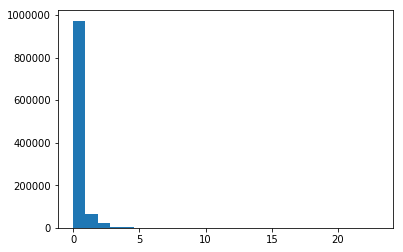

In [65]:
plt.hist(df_test['Signal']['signal_difference'].dropna(),bins=25); #into 15 equal parts 

In [48]:
df[(df['Timestamp']=='2019-08-23 10:07:11')&(df['HenID']=='9B')]

,Timestamp,HenID,Zone,PenID,Signal,test_correct_HenID,test_correct_PenID,day,date_toberemoved
6965201,2019-08-23 10:07:11,9B,Rampe 6-10,9,11,True,True,2019-08-23,False
6965202,2019-08-23 10:07:11,9B,Einstreu 6-10,9,13,True,True,2019-08-23,False


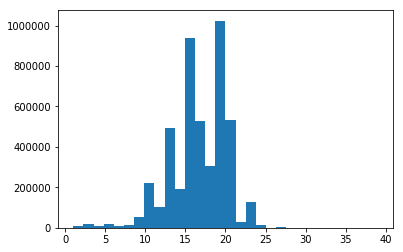

In [70]:
plt.hist(df['Signal'].dropna(),bins=30); #into 15 equal parts 

In [72]:
df.shape

(4644977, 9)

In [71]:
df[df['Signal']<9]

,Timestamp,HenID,Zone,PenID,Signal,test_correct_HenID,test_correct_PenID,day,date_toberemoved
204,2019-07-07 22:12:16,1A,Rampe 1-5,1,2,True,True,2019-07-07,False
208,2019-07-07 22:12:18,1A,Einstreu 1-5,1,8,True,True,2019-07-07,False
341,2019-07-07 22:14:38,1A,Rampe 1-5,1,2,True,True,2019-07-07,False
347,2019-07-07 22:14:43,1A,Einstreu 1-5,1,8,True,True,2019-07-07,False
673,2019-07-07 22:20:58,1A,Rampe 1-5,1,2,True,True,2019-07-07,False
675,2019-07-07 22:20:59,1A,Einstreu 1-5,1,8,True,True,2019-07-07,False
705,2019-07-07 22:21:48,1A,Rampe 1-5,1,3,True,True,2019-07-07,False
706,2019-07-07 22:21:51,1A,Einstreu 1-5,1,8,True,True,2019-07-07,False
822,2019-07-07 22:24:05,1A,Rampe 1-5,1,2,True,True,2019-07-07,False
824,2019-07-07 22:24:06,1A,Einstreu 1-5,1,8,True,True,2019-07-07,False


#### sort by date (timestamp), in case the log files were not open in the right order

In [ ]:
df = df.sort_values(['Timestamp'], ascending=True) #ts_order
df.head(5)

#### remove zone associated to wrong pen

In [ ]:
#example
df[(df['PenID']=='6')&(df['Zone']=='Rampe 1-5')].head(1)

In [ ]:
dico_zone_matching = {'Rampe 1-5': ['1','2','3','4','5'], 
                      'Einstreu 1-5':['1','2','3','4','5'], 
                      'Rampe 6-10':['6','7','8','9','10'],
                      'Einstreu 6-10':['6','7','8','9','10'], 
                      'Box1':['1'],  
                      'Box2':['1'], 
                      'Box3':['2'], 
                      'Box4':['2'], 
                      'Box5':['3'], 
                      'Box6':['3'], 
                      'Box7':['4'], 
                      'Box8':['4'], 
                      'Box9':['5'], 
                      'Box10':['5'], 
                      'Box11':['6'], 
                      'Box12':['6'], 
                      'Box13':['7'], 
                      'Box14':['7'], 
                      'Box15':['8'], 
                      'Box16':['8'], 
                      'Box17':['9'], 
                      'Box18':['9'], 
                      'Box19':['10'], 
                      'Box20':['10'], 
                      np.nan:['1','2','3','4','5','6','7','8','9','10']}

In [ ]:
df_corr = df.groupby(['PenID','Zone']).count().reset_index()
df_corr.to_csv(os.path.join(path_extracted_data,'df_Zone_associated_to_wrong_Pen.csv'),sep=';')
df_corr

In [ ]:
#faster than apply : df.apply(lambda x: x['PenID'] in dico_zone_matching[x['Zone']], axis=1)
df['test'] = df['PenID']+'/-/'+df['Zone']
df['is_correct_pen4zone'] = df['test'].map(lambda x: x.split('/-/')[0] in dico_zone_matching[x.split('/-/')[1]])
df.drop(['test'], inplace=True, axis=1)
df.head(3)

In [ ]:
df_corr = df[~df['is_correct_pen4zone']]
df_corr.to_csv(os.path.join(path_extracted_data,'df_Zone_associated_to_wrong_Pen_all_situation.csv'),sep=';')
df_corr

In [ ]:
print('We removed %d records which zone was associated to a wrong pen'%df[~df['is_correct_pen4zone']].shape[0])
df = df[df['is_correct_pen4zone']]
df.drop(['is_correct_pen4zone'],inplace=True,axis=1)
print(df.shape)
df.head(3)

#### handle flickering situations

#next record date NOT EFFICIENT
df['next_record_date'] = df.apply(lambda x: (list(df[(df['HenID']==x['HenID']) & \
                                                     (df['Timestamp']>x['Timestamp'])]['Timestamp'].values)+[np.nan])[0],axis=1)
df['duration'] = df.apply(lambda x: x['next_record_date']-x['Timestamp'], axis=1)

In [ ]:
#add next duration variable
li_df = []
#more efficient to do it per hen, as it wont need to search in the whole dataframe, and we can simply shift the timestamp column
for i, df_hen in tqdm.tqdm(df.groupby(['HenID'])):
    
    #as the next record date (sort by date, then simply shift by one row and add nan at then end)
    df_hen = df_hen.sort_values(['Timestamp'], ascending=True) #ts_order
    
    #same date, one must take the last recorded one & sorting by date might change it. Also it already should be sorted by date
    df_hen['next_record_date'] = df_hen['Timestamp'].tolist()[1:]+[np.nan]
    #compute duration
    df_hen['duration'] = df_hen.apply(lambda x: x['next_record_date']-x['Timestamp'], axis=1)
    
    #compute the last record date in order to put interzone also when the duration is >=nbr_sec
    df_hen['previous_record_date'] = [np.nan]+df_hen['Timestamp'].tolist()[0:-1]
    #compute previous duration in order to put interzone also when the duration is >=nbr_sec
    df_hen['previous_duration'] = [np.nan]+df_hen['duration'].tolist()[0:-1]
    
    li_df.append(df_hen)
    
#put again in one dataframe
df = pd.concat(li_df)
print(df.shape)
#dont care about the false positive warning
df.tail(10)

In [ ]:
#name it interzone when duration is less than 2 seconds
#note that there is no need to merge interzone in one timestamp as we will in any case extend to a time serie for analysis and
#keep only one second over two
df['Zone_without_flickering'] = df['Zone'].copy()
df.loc[df['duration']<dt.timedelta(seconds=nbr_sec),'Zone_without_flickering'] = 'Interzone'
#if its not interzone (i.e. its duration is longer than 3 seconds) and its previous duration is shorter than 3 seconds,
#then its the end of a flickering situation
df.loc[(df['previous_duration']<dt.timedelta(seconds=nbr_sec))&(df['Zone_without_flickering']!='Interzone'),
       'Zone_without_flickering'] = 'Interzone_f'
                                                                            
#we wont be doing this, as otherwise if the lasst timestamp are flickering situation, we will miss a zone
    #replace 'Zone_without_flickering' by np.nan if the duration is nan (i.e. if last observation)
#df.loc[pd.isnull(df['duration']),'Zone_without_flickering'] = np.nan

df.head(5)

In [ ]:
#differentiate between different interzones
#very long as we need to look at the next zone only once we have changed the next row
li_df = []
for i, df_hen in tqdm.tqdm(df.groupby(['HenID'])):
    
    df_hen['interzone_info'] = df_hen['Zone'].copy()
    df_hen['ToRemove'] = False
    df_hen = df_hen.reset_index()
    #as we will keep the first entry of consecutives equal zones, we will take the value from the next record to the previous 
    #one (and not the opposite way)
    #idea: keep the first interzone entry, and put all info about these interzones in the interzone_info column
    #start with the last row, and put the rule: if row is not the same as the one after then just add the actual zone as info,
    #otherwise if its the same then add the interzone info of now and after
    for i in reversed(range(1,df_hen.shape[0]-1)):
        xp = df_hen.iloc[i-1]
        x0 = df_hen.iloc[i]
        x1 = df_hen.iloc[i+1] #--> we can not deal with the last row of each df_hen, so we will remove it
        if (x0['Zone_without_flickering']!=x1['Zone_without_flickering']) & (x1['Zone_without_flickering']!='Interzone_f'):
            df_hen.at[i,'interzone_info'] = x0['Zone'] 
        else:
            df_hen.at[i,'interzone_info'] = x0['interzone_info']+', '+x1['interzone_info']
            
        #if its interzone and the previous one is interzone then remove it
        if ((x0['Zone_without_flickering']=='Interzone')|(x0['Zone_without_flickering']=='Interzone_f'))\
        & (xp['Zone_without_flickering']=='Interzone'):
            df_hen.at[i,'ToRemove'] = True
    #remove last row 
    df_hen = df_hen[0:-1]
    li_df.append(df_hen)
    
#put again in one dataframe
df = pd.concat(li_df)
print(df.shape)
#dont care about the false positive warning
df.tail(10)

In [ ]:
#verification OK
#df.tail(50)[['Timestamp','HenID','Zone','Zone_without_flickering']]
#df.tail(200)

In [ ]:
#correct names and keep the first interzone row
df['Zone_without_flickering_nodiff'] = df['Zone_without_flickering'].copy()

df['interzone_name'] = df['interzone_info'].map(lambda x: 'Interzone_'+\
                                                ''.join(sorted([j[0] for j in set([i.strip() for i in x.split(',')])])) )
df['Zone_without_flickering'] = np.where(df['Zone_without_flickering']=='Interzone', 
                                         df['interzone_name'], 
                                         df['Zone_without_flickering'])

#longer
#df['Zone_without_flickering'] = df.apply(lambda x: 'Interzone_'+''.join(sorted([j[0] for j in set([i.strip() for i in x['interzone_info'].split(',')])])) \
#                                         if x['Zone_without_flickering']=='Interzone' else x['Zone_without_flickering'], axis=1)

In [ ]:
df[['Timestamp','HenID','duration','Zone_without_flickering','interzone_info','ToRemove','Zone_without_flickering_nodiff',
    'interzone_name']].tail(200)

In [ ]:
df.tail(200)

In [ ]:
df.to_csv(os.path.join(path_extracted_data,'df_records_before_removing_flickering_situtation_.csv'), index=False,sep=';')

In [ ]:
#we remove NOW the interzones record that are not the first record and NOT BEFOREHAND, in order to verify things all together
#remove interzone that are not the first one
x0 = df.shape[0]
df = df[df['ToRemove']==False]
#Now, duration/previous_record_date/next_record_date makes no more sense for interzone and consecutives equal records, so lets 
#remove it
df.drop(['duration','previous_duration','previous_record_date','ToRemove','Zone_without_flickering_nodiff',
        'interzone_name','index'], inplace=True, axis=1)
print('We remove %d records due to flickering situations, we are left now with %d records'%(x0-df.shape[0],df.shape[0]))

In [ ]:
[x for x in df['Zone_without_flickering'].unique() if str(x).startswith('Interzone')]

In [ ]:
df['Zone_without_flickering'].value_counts()

In [ ]:
df[df['Zone_without_flickering']=='Interzone_BR']

#### remove consecutives equal Zone for same hens at (not strictly) more than nbr_second second duration ?

In [ ]:
#add next zone based on Zone_without_flickering (for quality verification)
li_df = []
#more efficient to do it per hen, as it wont need to search in the whole dataframe, and we can simply shift the timestamp column
for i, df_hen in tqdm.tqdm(df.groupby(['HenID'])):
    
    #as the next record date (sort by date, then simply shift by one row and add nan at then end)
    df_hen = df_hen.sort_values(['Timestamp'], ascending=True) #ts_order
    #same date, one must take the last recorded one & sorting by date might change it. Also it already shoul dbe sorted by date
    df_hen['next_zone'] = df_hen['Zone_without_flickering'].tolist()[1:]+[np.nan]
    
    li_df.append(df_hen)
    
#put again in one dataframe
df = pd.concat(li_df)
print(df.shape)
#dont care about the false positive warning
df.tail(10)

In [ ]:
df[df['Zone_without_flickering'].isnull()]

In [ ]:
#True if next zone is equal to the actual zone (Zone_without_flickering) 
df['correction_is_consecutive_equal_zone'] = False
df['Zone_without_flickering'] = df['Zone_without_flickering'].fillna('')
df['is_flick'] = df['Zone_without_flickering'].map(lambda x: x.startswith('Interzone') if x!='' else False)
df.loc[(df['next_zone']==df['Zone_without_flickering']) & (~df['is_flick']), 'correction_is_consecutive_equal_zone'] = True
df_test = df[df['correction_is_consecutive_equal_zone']]
print('There is %d records that has same zone than the previous one without being a flickering situation, \
we wont remove these records from the clean_record file as it wont change anything for the time serie' %df_test.shape[0])
df_test

In [ ]:
df_test['Zone_without_flickering'].unique()

In [ ]:
df_test[df_test['day']=='2019-07-11']

In [ ]:
df_test.filter(['HenID','Timestamp','Zone_without_flickering','next_record_date',
                'next_zone']).to_csv(os.path.join(path_extracted_data,'df_consecutives_equal_zone.csv'), index=False, sep=';')

In [ ]:
#as we simply want to keep the first one, its the same as not doing anything. In case we would do something, then we would
#also differencitae the interzone name here

#### save it

In [ ]:
df.drop(['next_record_date','next_zone'], inplace=True, axis=1)
df.to_csv(os.path.join(path_extracted_data,'df_clean_records.csv'), sep=';', index=False)

In [ ]:
END_TIME = time.clock()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))